<span style="font-size:2em;">Spaceship Travel Prediction</span>

**Business Problem:** 

To help rescue crews and retrieve the lost passengers, the challenge is to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

#### Libraries and data preparation

In [1]:
import sweetviz as sv
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, cross_val_score
from pycaret.classification import *
import lightgbm as lgb
from scipy.stats import mannwhitneyu
import optuna

from functions.unpooled_confidence_interval import calculate_unpooled_confidence_interval



In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

In [3]:
custom_palette = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462']
sns.set_palette(custom_palette)
sns.set_style("white")
sns.set(rc={'figure.figsize': (8, 4)})
sns.set_palette(custom_palette)

In [4]:
spaceship_df = pd.read_csv('data/train.csv')
spaceship_df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

#### Exploratory data analysis

In [6]:
profile = ProfileReport(spaceship_df, title='Spaceship dataset profiling report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From initial data exploration it is visible that most of the columns have at least some missing data. Since it is not a small number of missing values, those will be imputed. 

PassengerId is fully populated and is providing additional information on each traveller - whether they are travelling or with someone else (family, pair, group). This column itself would add high cardinality to the ML model, but extracted information will be valuable to model. 

HomePlanet has three distinct values - Earth, Europa and Mars, with 2.3% of missing values. The most common home planet is Earth. 

CryoSleep provides information whether the person was put into a suspended animation for the duration of the voyage. 62% of the dataset was not, 35% was confined to their cabins, the rest ar missing values. 

Cabin is another high cardinality feature, with 2% of missing values. however, it provides additional information such as deck, number and side of the cabin, which will be extracted for further feature engineering. 

Destination has three different categories, the most popular being Trappist-1e covering the 69% of the dataset.

VIP - most of the travellers does not have VIP purchased, 95% did not have it, there are 2% of missing values. 

There is also information on RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - the amount each passenger spent in the luxury amenities. We can see that most of the travellers did not spend money on these perks. 

The final Transported value has no imbalance, True and False divided almost be half. (50.4%/49.6%)

For the sake of the clean notebook, the initial modelling was removed. Using raw data no outcome was reached because of the high cardinality, having removed highly cardinal features performance was low using raw data. 

#### Feature Engineering

In [7]:
def string_split(df):
    """
    Splits the 'PassengerId' and 'Cabin' columns of the dataframe into multiple columns.

    Args:
        df (pd.DataFrame): DataFrame containing the columns 'PassengerId' and 'Cabin'.

    Returns:
        pd.DataFrame: Modified DataFrame with new columns 'group_id', 'individual_number', 'cabin_deck', 'cabin_number', and 'cabin_side'.
    """
    df[['group_id', 'individual_number']] = df['PassengerId'].str.split('_', expand=True)
    df[['cabin_deck', 'cabin_number', 'cabin_side']] = df['Cabin'].str.split('/', expand=True)

    numeric = ['individual_number', 'cabin_number']
    for column in numeric:
        df[column] = df[column].astype(float)
    return df


def mapping_group_size(df):
    """
    Adds a 'group_size' column to the DataFrame, indicating the size of the group each passenger belongs to.

    Args:
        df (pd.DataFrame): DataFrame containing the 'group_id' and 'individual_number' columns.

    Returns:
        pd.DataFrame: Modified DataFrame with a new 'group_size' column.
    """
    group_size_df = pd.DataFrame(df.groupby('group_id')['individual_number'].max())
    group_size_df = group_size_df.rename(columns={'individual_number': 'group_size'})
    group_size_df['group_size'] = group_size_df['group_size'].astype(int)
    df = df.merge(group_size_df, how='inner', on='group_id', copy=False)
    return df

def numeric_imputer(df):
    """
    Imputes missing values in numeric columns of the DataFrame with zero.

    Args:
        df (pd.DataFrame): DataFrame containing numeric columns with potential missing values.

    Returns:
        pd.DataFrame: Modified DataFrame with missing values in numeric columns replaced by zero.
    """
    numerical_cols = df.select_dtypes(include=['number']).columns
    null_cols = df.columns[df.isnull().any()]
    numerical_null_cols = [col for col in numerical_cols if col in null_cols]
    
    for column in numerical_null_cols:
        df[column] = df[column].fillna(0)

    return df

def categorical_imputer(df):
    """
    Imputes missing values in categorical columns of the DataFrame with the mode (most frequent value).

    Args:
        df (pd.DataFrame): DataFrame containing categorical columns with potential missing values.

    Returns:
        pd.DataFrame: Modified DataFrame with missing values in categorical columns replaced by the mode.
    """
    categorical_cols = df.select_dtypes(include=['object']).columns
    null_cols = df.columns[df.isnull().any()]
    categorical_null_cols = [col for col in categorical_cols if col in null_cols]

    for column in categorical_null_cols:
        mode_value = df[column].mode()[0]
        df[column] = df[column].fillna(mode_value)
        
    return df

def create_spendings_column(df):
    """
    Creates a new column 'spendings' in the DataFrame, representing the total spendings across several categories.

    Args:
        df (pd.DataFrame): DataFrame containing spending columns 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', and 'VRDeck'.

    Returns:
        pd.DataFrame: Modified DataFrame with a new 'spendings' column.
    """
    spendings_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[spendings_columns] = df[spendings_columns].fillna(0)
    df['spendings'] = df[spendings_columns].sum(axis=1)
    return df


In [8]:
def full_dataframe_preprocessing(df):
    """
    Performs a series of preprocessing steps on the DataFrame:
    1. Splits 'PassengerId' and 'Cabin' columns into multiple columns.
    2. Maps the size of each group and adds it as a new column.
    3. Imputes missing values in numeric columns with zero.
    4. Imputes missing values in categorical columns with the mode.
    5. Creates a new 'spendings' column by summing specified spending columns.
    6. Drops unnecessary columns.

    Args:
        df (pd.DataFrame): Input DataFrame containing raw data with columns 'PassengerId', 'Cabin', etc.

    Returns:
        pd.DataFrame: Fully processed DataFrame ready for further analysis or modeling.
    """
    df = string_split(df)
    df = mapping_group_size(df)
    df = numeric_imputer(df)
    df = categorical_imputer(df)
    df = create_spendings_column(df)
    df = df.drop(['PassengerId', 'Name', 'Cabin', 'group_id', 'individual_number'], axis=1)
    return df


In [9]:
preprocessed_df = full_dataframe_preprocessing(spaceship_df)

In [10]:
preprocessed_df

HomePlanet  CryoSleep    Destination   Age    VIP  RoomService  \
0        Europa      False    TRAPPIST-1e  39.0  False          0.0   
1         Earth      False    TRAPPIST-1e  24.0  False        109.0   
2        Europa      False    TRAPPIST-1e  58.0   True         43.0   
3        Europa      False    TRAPPIST-1e  33.0  False          0.0   
4         Earth      False    TRAPPIST-1e  16.0  False        303.0   
...         ...        ...            ...   ...    ...          ...   
8688     Europa      False    55 Cancri e  41.0   True          0.0   
8689      Earth       True  PSO J318.5-22  18.0  False          0.0   
8690      Earth      False    TRAPPIST-1e  26.0  False          0.0   
8691     Europa      False    55 Cancri e  32.0  False          0.0   
8692     Europa      False    TRAPPIST-1e  44.0  False        126.0   

      FoodCourt  ShoppingMall     Spa  VRDeck  Transported cabin_deck  \
0           0.0           0.0     0.0     0.0        False          B   
1           9.0          25.0   549.0    44.0         True          F   
2        3576.0           0.0  6715.0    49.0        False          A   
3        1283.0         371.0  3329.0   193.0        False          A   
4          70.0         151.0   565.0     2.0         True          F   
...         ...           ...     ...     ...          ...        ...   
8688     6819.0           0.0  1643.0    74.0        False          A   
8689        0.0           0.0     0.0     0.0        False          G   
8690        0.0        1872.0     1.0     0.0         True          G   
8691     1049.0           0.0   353.0  3235.0        False          E   
8692     4688.0           0.0     0.0    12.0         True          E   

      cabin_number cabin_side  group_size  spendings  
0              0.0          P           1        0.0  
1              0.0          S           1      736.0  
2              0.0          S           2    10383.0  
3              0.0          S           2     5176.0  
4              1.0          S           1     1091.0  
...            ...        ...         ...        ...  
8688          98.0          P           1     8536.0  
8689        1499.0          S           1        0.0  
8690        1500.0          S           1     1873.0  
8691         608.0          S           2     4637.0  
8692         608.0          S           2     4826.0  

[8693 rows x 16 columns]

#### Statistical Inference 

**Null hypothesis:** There is no significant difference in mean values of spendings for travellers that were transported and not

**Alternative hypothesis:** There is significant difference in mean values of spendings for travellers that were transported and not


Data is not normally distributed, I will be using non-parametric test (Mann Whitney U test)

In [26]:
was_transported = preprocessed_df[preprocessed_df['Transported'] == True]['spendings']
was_not_transported = preprocessed_df[preprocessed_df['Transported'] == False]['spendings']

test_results = mannwhitneyu(
    was_transported, was_not_transported)
"Test stat: {:.4f} | P-value: {:.4f}".format(
    test_results.statistic,
    test_results.pvalue
)

'Test stat: 5043344.5000 | P-value: 0.0000'

There is a significant difference, since p-value is below 0.05 (significance level)

In [29]:
lower, upper = calculate_unpooled_confidence_interval(
    was_not_transported, was_transported, confidence=0.95)
"Lower bound: {:.4f}, Upper bound: {:.4f}".format(lower, upper)

'Lower bound: 1002.6861, Upper bound: 1234.2341'

After calculating the interval, it is evident that spendings were higher those who was transported. 

#### Modelling

Having created additional features, I will be using PyCaret AutoML tool to find the best performing model for this dataset. 14 diferrent models will be fitted with calculated accuracy and other important metrics.

In [11]:
s = setup(preprocessed_df, target = 'Transported', session_id=555)
exp = ClassificationExperiment()
exp.setup(preprocessed_df, target ='Transported', session_id= 123)

In [12]:
best = exp.compare_models()

The summary table for each of the tried out model, it is visible that the best performing is light gradient boosting machine model, with accuracy of 0.8015. Since the dataset is balanced, it is a good metric to be compared against. 

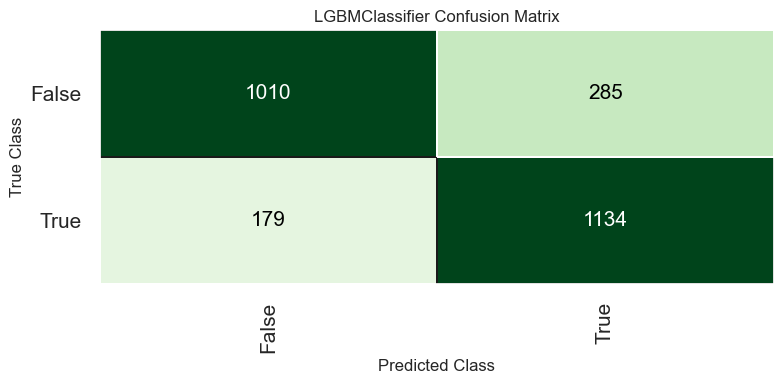

In [13]:
plot_model(best, plot='confusion_matrix')

When comparing True Positive, True Negatives and False Positive, False Negatives, it is visible that it is predicting outcome classes with similar accuracy. 

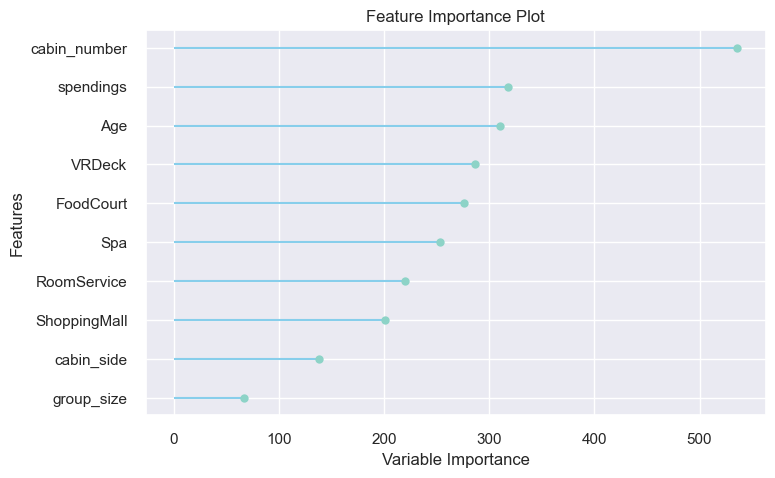

In [14]:
plot_model(best, plot = 'feature')

One of the pycaret functionalities allows us to see which features did the biggest contribution to the outcome class. We can see that cabin_number (as detected during EDA phase) has the biggest variable importance, followed by spendings and age. 

Since it was decided that lightgbm has the biggest accuracy score, I will use it for further hyperparameter tuning for faster outcome as well as more controlled parameter grid defintion. 

In [15]:

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(preprocessed_df)

categorical_preprocessor = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_preprocessor, categorical_columns),
    ],
    remainder="passthrough",
)

model_lgb = lgb.LGBMClassifier()
model_pipeline_lgb=make_pipeline(preprocessor, model_lgb)


In [16]:
target = preprocessed_df['Transported']
data = preprocessed_df.drop(['Transported'], axis=1)
data_train, data_test, target_train, target_test = train_test_split(
    data, target, stratify=target, random_state=5412)

In [20]:
def objective(trial):
    param = {
        'lgbmclassifier__verbose': -1,
        'lgbmclassifier__num_leaves': trial.suggest_int('num_leaves', 16, 50),
        'lgbmclassifier__colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.7),
        'lgbmclassifier__min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'lgbmclassifier__subsample': trial.suggest_float('subsample', 0.7, 1),
        'lgbmclassifier__reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Train the model
    model = model_pipeline_lgb.set_params(**param)
    model.fit(data_train, target_train)

    # Perform cross-validation
    score = cross_val_score(model, data_train, target_train, cv=3, scoring='accuracy').mean()
    
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-08-07 22:46:11,850] A new study created in memory with name: no-name-a7d7eef8-b336-4652-9967-e7fa9ccf1242
[I 2024-08-07 22:46:13,129] Trial 0 finished with value: 0.7985887406043872 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.20591861476781517, 'min_child_samples': 17, 'subsample': 0.8629472423294428, 'reg_lambda': 4.809980695645724}. Best is trial 0 with value: 0.7985887406043872.
[I 2024-08-07 22:46:14,626] Trial 1 finished with value: 0.8025770823745972 and parameters: {'num_leaves': 44, 'colsample_bytree': 0.6631716127285502, 'min_child_samples': 83, 'subsample': 0.9334235853670978, 'reg_lambda': 1.048896748717334}. Best is trial 1 with value: 0.8025770823745972.
[I 2024-08-07 22:46:15,414] Trial 2 finished with value: 0.8076392084675564 and parameters: {'num_leaves': 16, 'colsample_bytree': 0.30527946469373557, 'min_child_samples': 77, 'subsample': 0.9247737086912221, 'reg_lambda': 1.26318787478501}. Best is trial 2 with value: 0.8076392084675564.
[I 2024-08-0

Number of finished trials: 100
Best trial: {'num_leaves': 24, 'colsample_bytree': 0.5823623986876232, 'min_child_samples': 80, 'subsample': 0.7908139909861288, 'reg_lambda': 3.9684606928046167}


In [21]:
best_params = study.best_trial.params
best_params_prefixed = {f'lgbmclassifier__{k}': v for k, v in study.best_params.items()}
model_pipeline_lgb.set_params(**best_params_prefixed)
print(classification_report(target_test, model_pipeline_lgb.predict(data_test)))

              precision    recall  f1-score   support

       False       0.83      0.81      0.82      1079
        True       0.81      0.83      0.82      1095

    accuracy                           0.82      2174
   macro avg       0.82      0.82      0.82      2174
weighted avg       0.82      0.82      0.82      2174



The accuracy was improved by the 0.02, which was expected. High performance improvement could lead to overfitting the dataset which will be avoided

#### Additional feature engineering

In [19]:
def age_boxing(x):
    if x < 13:
        return 'Child'
    elif x < 19:
        return 'Teen'
    elif x < 39:
        return 'Adult'
    elif x < 59:
        return 'Middle Age Adult'
    else:
        return 'Senior Adult'

def spendings(x):
    if x > 0:
        return True
    else:
        return False


def additional_feature_engineering(df):    
    spendings_columns = ['RoomService', 'FoodCourt', 'ShoppingMall' , 'Spa', 'VRDeck']
    new_df = df.copy()
    for column in spendings_columns:
        new_column_name = f'{column}_bool'
        new_df[new_column_name] = df[column].apply(spendings)

    new_df['age_box'] = new_df['Age'].apply(age_boxing)
    new_df['cabin_number_box'] = pd.cut(new_df['Age'], bins=4, labels=False)
    return new_df


In [20]:
copied_df = additional_feature_engineering(preprocessed_df)
data = copied_df.drop(columns='Transported', axis=1)
target = copied_df['Transported']

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomePlanet         8693 non-null   object 
 1   CryoSleep          8693 non-null   bool   
 2   Destination        8693 non-null   object 
 3   Age                8693 non-null   float64
 4   VIP                8693 non-null   bool   
 5   RoomService        8693 non-null   float64
 6   FoodCourt          8693 non-null   float64
 7   ShoppingMall       8693 non-null   float64
 8   Spa                8693 non-null   float64
 9   VRDeck             8693 non-null   float64
 10  cabin_deck         8693 non-null   object 
 11  cabin_number       8693 non-null   float64
 12  cabin_side         8693 non-null   object 
 13  group_size         8693 non-null   int64  
 14  spendings          8693 non-null   float64
 15  RoomService_bool   8693 non-null   bool   
 16  FoodCourt_bool     8693 

In [22]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_preprocessor, categorical_columns),
    ],
    remainder="passthrough",
)

model_lgb2 = lgb.LGBMClassifier()
model_pipeline_lgb2=make_pipeline(preprocessor, model_lgb)
model_pipeline_lgb2.fit(data, target)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                feature_name_combiner='concat',
                                                                handle_unknown='error',
                                                                max_categories=None,
                                                                min_frequency=None,
                                                                sparse_output=Tr...
                                colsample_bytree=0.45664539856124176,
                                importance_type='split', learning_rate=0.1,
                                max_depth=-1, min_child_samples=78,
                                min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=100, n_jobs=None, num_leaves=22,
                                objective=None, random_state=None,
                                reg_alpha=0.0, reg_lambda=0.9367908499369648,
                                subsample=0.8262227016235482,
                                subsample_for_bin=200000, subsample_freq=0,
                                verbose=-1))],
         verbose=False)

In [23]:
score = cross_val_score(model_pipeline_lgb2, data, target, cv=10, scoring='accuracy').mean()
score

0.7908749652791556

Additional feature enginnering by boxing age, spendings and cabin_number did not gave a performance boost, it alternatively, reduced. the previous final model will be used for kaggle submission. 

#### Submission to kaggle

In [24]:
test = pd.read_csv('data/test.csv')
test_df = full_dataframe_preprocessing(test)
submission = pd.DataFrame(test['PassengerId'])
submission['Transported'] = model_pipeline_lgb.predict(test_df).astype(bool)
submission

PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]

In [25]:
submission.to_csv('submission2.csv', index=False)